In [25]:
# Importing necessary libraries
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier  
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [26]:
# Now load the encoded dataset.
df1 = pd.read_csv('encoded_retractions35215_V10.csv')
df1.head()

,Journal,ArticleType,CitationCount,SJR Best Quartile,SJR,H index,TimeToRetraction,IsInternationalCollaboration,ArticleAge,IsPaywalled,LevelOfSeriousness,Subject,Institution,Publisher,Country,Author,Cluster
0,4884,56,5,1.0,0.900000,315.000000,280,0,304,0,3.0,0.194505,0.125899,0.028624,0.001657,0.000010,1
1,3474,56,2,3.0,0.290000,23.000000,1089,0,1115,0,3.0,0.156626,0.062955,0.099475,0.011070,0.000009,1
2,3474,56,14,3.0,0.290000,23.000000,1344,0,1367,0,3.0,0.156626,0.062955,0.099475,0.011070,0.000008,1
3,5106,10,0,5.0,1.458473,157.555562,0,0,492,0,1.0,0.232383,0.050368,0.099475,0.064331,0.000009,1
4,964,56,2,1.0,0.764000,48.000000,351,1,520,0,0.0,0.166709,0.035978,0.116854,0.024918,0.000009,4


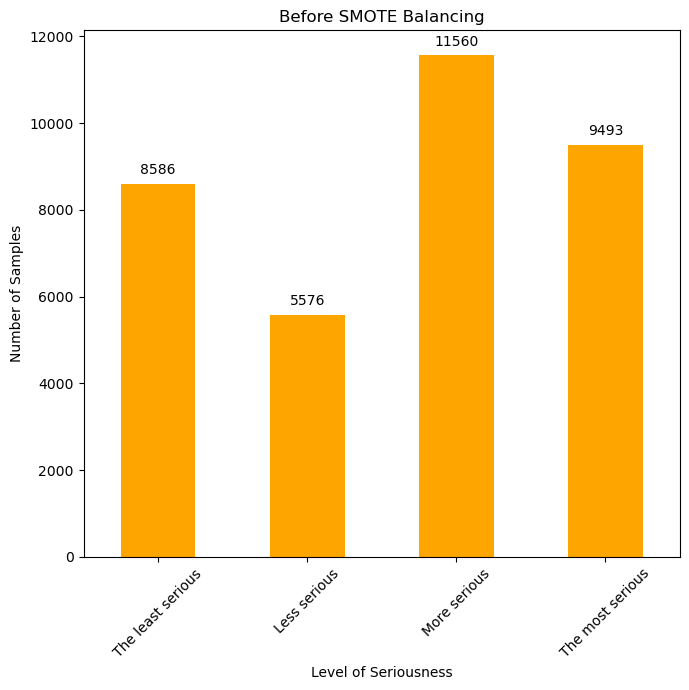

In [27]:
# Check the balance of 4 subsets in the dataset.
label_counts = df1['LevelOfSeriousness'].value_counts().sort_index()  # Ensure the labels are sorted

plt.figure(figsize=(7, 7))
ax = label_counts.plot(kind='bar', color='orange')  # 'ax' captures the plot axes
plt.title('Before SMOTE Balancing')
plt.xlabel('Level of Seriousness')
plt.ylabel('Number of Samples')

# Set custom x-tick labels
plt.xticks(ticks=range(4), labels=['The least serious', 'Less serious', 'More serious', 'The most serious'], rotation=45)

# Annotate each bar with its height value
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

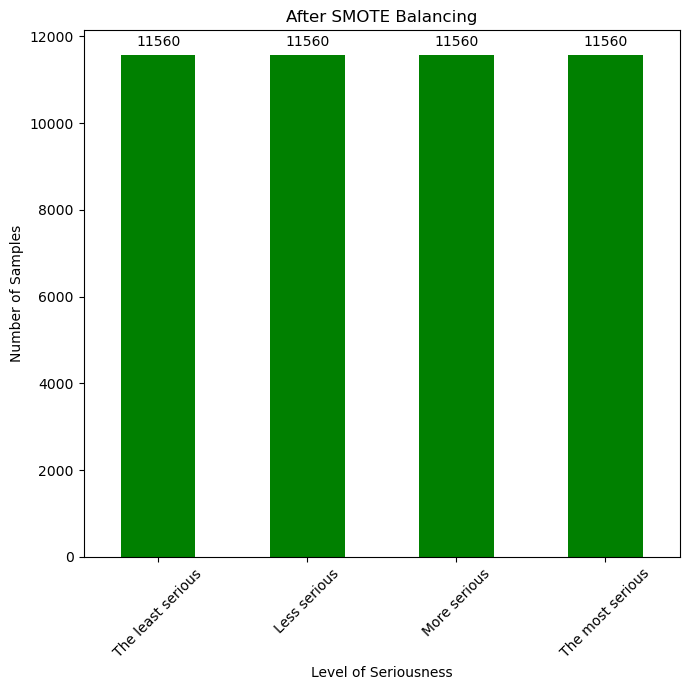

In [28]:
# Separate feataures and the target variable
X = df1.drop('LevelOfSeriousness', axis=1)
y = df1['LevelOfSeriousness']

# Apply SMOTE
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert y_resampled to a DataFrame and count the occurrences of each class
y_resampled_df = pd.DataFrame(y_resampled, columns=['LevelOfSeriousness'])
label_counts_resampled = y_resampled_df['LevelOfSeriousness'].value_counts().sort_index()

# Plot the balanced data
plt.figure(figsize=(7, 7))
ax = label_counts_resampled.plot(kind='bar', color='green')  # 'ax' captures the plot axes
plt.title('After SMOTE Balancing')
plt.xlabel('Level of Seriousness')
plt.ylabel('Number of Samples')

# Set custom x-tick labels
plt.xticks(ticks=range(4), labels=['The least serious', 'Less serious', 'More serious', 'The most serious'], rotation=45)

# Annotate each bar with its height value
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

### Feature Selection based on feature importance

In [29]:
# Function to run Random Forests model
def RF_full_features(X, y):
    # For Random Forest, preprocessing like standardization is not necessary, but let's keep the dataset split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Initialize the Random Forest classifier
    rfc = RandomForestClassifier(random_state=0)
    
    # Applying 5-fold cross-validation
    cv_results = cross_validate(rfc, X_train, y_train, cv=5,
                                scoring=('accuracy', 'precision_macro', 'recall_macro', 'f1_macro'))
    
    # Training the model on the full training data
    rfc.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = rfc.predict(X_test)
    
    # Evaluation metrics
    accuracy_RF = accuracy_score(y_test, y_pred)
    precision_RF = precision_score(y_test, y_pred, average='macro')
    recall_RF = recall_score(y_test, y_pred, average='macro')
    f1_RF = f1_score(y_test, y_pred, average='macro')
    
    print("Accuracy:", accuracy_RF)
    print("Precision:", precision_RF)
    print("Recall:", recall_RF)
    print("F1-Score:", f1_RF)

    return rfc, accuracy_RF, precision_RF, recall_RF, f1_RF

In [30]:
# RF with all features
rfc, accuracy_RF0, precision_RF0, recall_RF0, f1_RF0 = RF_full_features(X_resampled, y_resampled)

Accuracy: 0.7840614186851211
Precision: 0.7955785149752016
Recall: 0.7847880179301802
F1-Score: 0.786490118392096


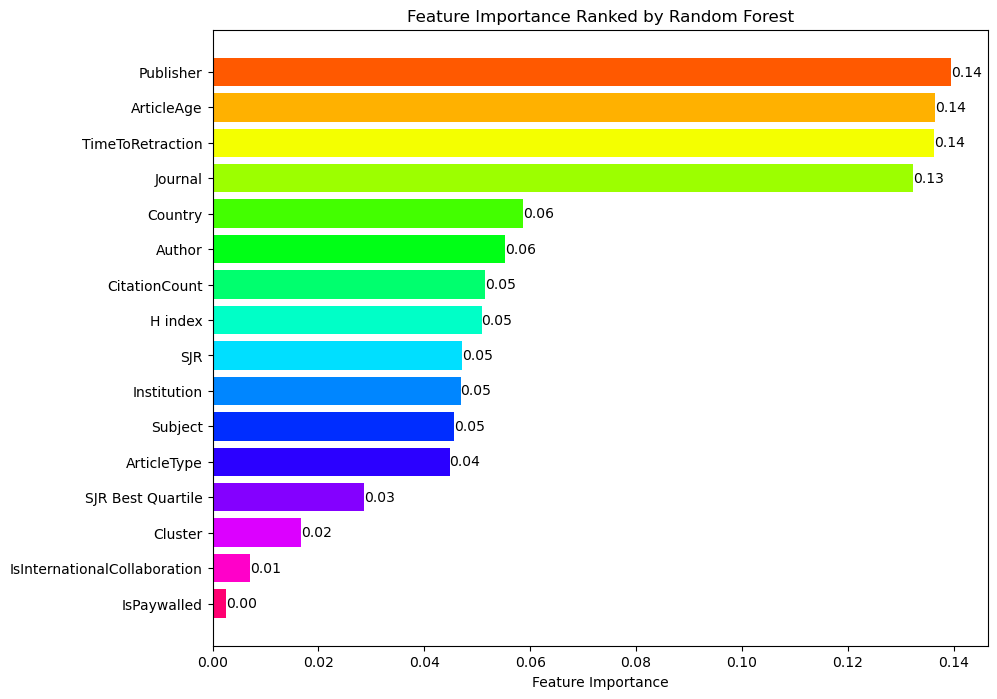

In [31]:
# Get feature importance
feature_importances = rfc.feature_importances_

# Get feature names
feature_names = X.columns.tolist() 

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = [feature_names[index] for index in sorted_idx]

# Generate a color palette with enough colors
colors = sns.color_palette("hsv", len(sorted_feature_names))

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color=colors, align='center')

# Add labels to the bars
for bar, value in zip(bars, sorted_feature_importances):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             '{:.2f}'.format(value),  # Format the value to 2 decimal places
             va='center', ha='left')

plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Ranked by Random Forest')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top

plt.show()

#### Feature Selection

Apply Backward elimination method: Remove feature one by one then rerun the models

##### RF with 15 predictors

In [32]:
columns_to_drop = ['IsPaywalled']
df15 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X15 = df15.drop('LevelOfSeriousness', axis=1)
y15 = df15['LevelOfSeriousness']

# RF with 11 most important features
rfc15, accuracy_RF15, precision_RF15, recall_RF15, f1_RF15 = RF_full_features(X15, y15)

Accuracy: 0.7421553315348574
Precision: 0.718915010240013
Recall: 0.7194196143927087
F1-Score: 0.7174828224537496


##### RF with 14 predictors

In [33]:
columns_to_drop = ['IsPaywalled', 'IsInternationalCollaboration']
df14 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X14 = df14.drop('LevelOfSeriousness', axis=1)
y14 = df14['LevelOfSeriousness']

# RF with 10 most important features
rfc14, accuracy_RF14, precision_RF14, recall_RF14, f1_RF14 = RF_full_features(X14, y14)

Accuracy: 0.7451370154763595
Precision: 0.7233125706999773
Recall: 0.7236521582787996
F1-Score: 0.72196219569951


##### RF with 13 predictors

In [34]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster']
df13 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X13 = df13.drop('LevelOfSeriousness', axis=1)
y13 = df13['LevelOfSeriousness']

# RF with 9 most important features
rfc13, accuracy_RF13, precision_RF13, recall_RF13, f1_RF13 = RF_full_features(X13, y13)

Accuracy: 0.7442851057787875
Precision: 0.7218247531963716
Recall: 0.7221091056986718
F1-Score: 0.7204202977661924


##### RF with 12 predictors

In [35]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile']
df12 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X12 = df12.drop('LevelOfSeriousness', axis=1)
y12 = df12['LevelOfSeriousness']

# RF with 8 most important features
rfc12, accuracy_RF12, precision_RF12, recall_RF12, f1_RF12 = RF_full_features(X12, y12)

Accuracy: 0.7413034218372853
Precision: 0.7181906568720892
Recall: 0.7189193839381945
F1-Score: 0.7171909192696322


##### RF with 11 predictors

In [36]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType']
df11 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X11 = df11.drop('LevelOfSeriousness', axis=1)
y11= df11['LevelOfSeriousness']

# RF with 7 most important features
rfc11, accuracy_RF11, precision_RF11, recall_RF11, f1_RF11 = RF_full_features(X11, y11)

Accuracy: 0.7410194519380946
Precision: 0.718288361382344
Recall: 0.7184446091569037
F1-Score: 0.7166164331061431


##### RF with 10 predictors

In [37]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject']
df10 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X10 = df10.drop('LevelOfSeriousness', axis=1)
y10 = df10['LevelOfSeriousness']

# RF with 6 most important features
rfc10, accuracy_RF10, precision_RF10, recall_RF10, f1_RF10 = RF_full_features(X10, y10)

Accuracy: 0.738321737895783
Precision: 0.7155207317567054
Recall: 0.7158286367587491
F1-Score: 0.7138702080267265


##### RF with 9 predictors

In [38]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution']
df9 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X9 = df9.drop('LevelOfSeriousness', axis=1)
y9 = df9['LevelOfSeriousness']

# RF with 5 most important features
rfc9, accuracy_RF9, precision_RF9, recall_RF9, f1_RF9 = RF_full_features(X9, y9)

Accuracy: 0.7357660088030669
Precision: 0.7120173368114908
Recall: 0.7132736941667823
F1-Score: 0.7111298743945346


##### RF with 8 predictors

In [39]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR']
df8 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X8 = df8.drop('LevelOfSeriousness', axis=1)
y8 = df8['LevelOfSeriousness']

# RF with 4 most important features
rfc8, accuracy_RF8, precision_RF8, recall_RF8, f1_RF8 = RF_full_features(X8, y8)

Accuracy: 0.7364759335510436
Precision: 0.7127106919322164
Recall: 0.7128028690099004
F1-Score: 0.7112158826161024


##### RF with 7 predictors

In [40]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR','H index']
df7 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X7 = df7.drop('LevelOfSeriousness', axis=1)
y7 = df7['LevelOfSeriousness']

# RF with 3 most important features
rfc7, accuracy_RF7, precision_RF7, recall_RF7, f1_RF7 = RF_full_features(X7, y7)

Accuracy: 0.7299446258696578
Precision: 0.7055862882208259
Recall: 0.7048463591523122
F1-Score: 0.7038320961548855


##### RF with 6 predictors

In [41]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR','H index','CitationCount']
df6 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X6 = df6.drop('LevelOfSeriousness', axis=1)
y6 = df6['LevelOfSeriousness']

# RF with 2 most important features
rfc6, accuracy_RF6, precision_RF6, recall_RF6, f1_RF6 = RF_full_features(X6, y6)

Accuracy: 0.7306545506176345
Precision: 0.7050599325909872
Recall: 0.7042324033963054
F1-Score: 0.7032470038492111


##### RF with 5 predictor

In [43]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR','H index','CitationCount','Author']
df5 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X5 = df5.drop('LevelOfSeriousness', axis=1)
y5 = df5['LevelOfSeriousness']

# RF with 1 most important feature
rfc5, accuracy_RF5, precision_RF5, recall_RF5, f1_RF5 = RF_full_features(X5, y5)

Accuracy: 0.7184438449524351
Precision: 0.6923775524140391
Recall: 0.6933082510162123
F1-Score: 0.6919491772198059


##### RF with 4 predictor

In [44]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR','H index','CitationCount','Author','Country']
df4 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X4 = df4.drop('LevelOfSeriousness', axis=1)
y4 = df4['LevelOfSeriousness']

# RF with 1 most important feature
rfc4, accuracy_RF4, precision_RF4, recall_RF4, f1_RF4 = RF_full_features(X4, y4)

Accuracy: 0.7096407780775238
Precision: 0.6819300274350977
Recall: 0.6830478718420425
F1-Score: 0.6818543733247862


##### RF with 3 predictor

In [45]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR','H index','CitationCount','Author','Country','Journal']
df3 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X3 = df3.drop('LevelOfSeriousness', axis=1)
y3 = df3['LevelOfSeriousness']

# RF with 1 most important feature
rfc3, accuracy_RF3, precision_RF3, recall_RF3, f1_RF3 = RF_full_features(X3, y3)

Accuracy: 0.6793979838137157
Precision: 0.6453534876701101
Recall: 0.6439564620893206
F1-Score: 0.6438180103215746


##### RF with 2 predictor

In [46]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR','H index','CitationCount','Author','Country','Journal','TimeToRetraction']
df2 = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X2 = df2.drop('LevelOfSeriousness', axis=1)
y2 = df2['LevelOfSeriousness']

# RF with 1 most important feature
rfc2, accuracy_RF2, precision_RF2, recall_RF2, f1_RF2 = RF_full_features(X2, y2)

Accuracy: 0.5971886979980122
Precision: 0.5648318782677367
Recall: 0.5640890983984689
F1-Score: 0.5640203399465282


##### RF with 1 predictor

In [47]:
columns_to_drop = ['IsPaywalled','IsInternationalCollaboration','Cluster','SJR Best Quartile','ArticleType','Subject','Institution','SJR','H index','CitationCount','Author','Country','Journal','TimeToRetraction','ArticleAge']
df1a = df1.drop(columns=columns_to_drop)
# Separate feataures and the target variable
X1a= df1a.drop('LevelOfSeriousness', axis=1)
y1a = df1a['LevelOfSeriousness']

# RF with 1 most important feature
rfc1, accuracy_RF1, precision_RF1, recall_RF1, f1_RF1 = RF_full_features(X1a, y1a)

Accuracy: 0.6130910123526906
Precision: 0.6088883857199365
Recall: 0.5837986839667831
F1-Score: 0.5856465218439671


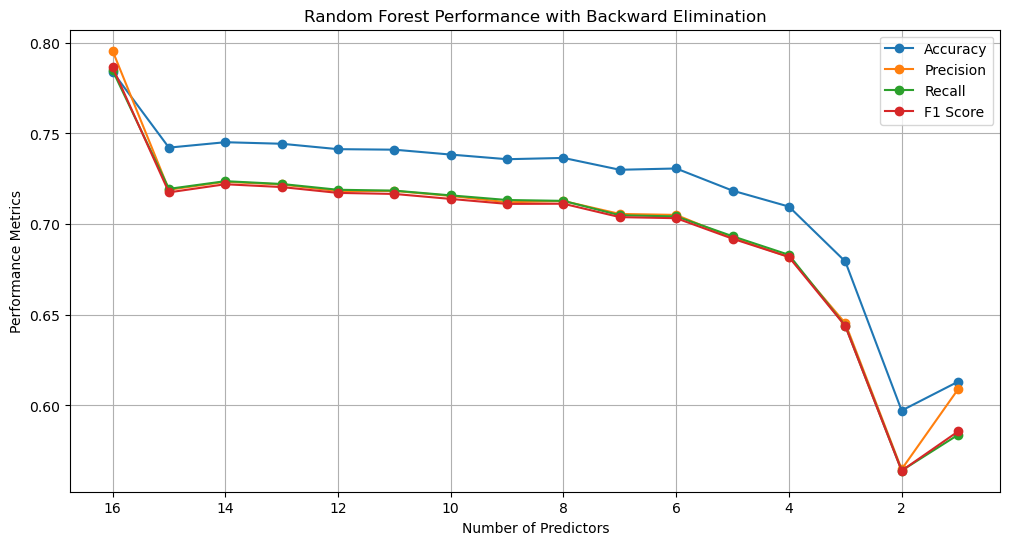

In [48]:
accuracy = [accuracy_RF0, accuracy_RF15, accuracy_RF14, accuracy_RF13, accuracy_RF12,accuracy_RF11, accuracy_RF10, accuracy_RF9, accuracy_RF8, accuracy_RF7, accuracy_RF6, accuracy_RF5, accuracy_RF4, accuracy_RF3, accuracy_RF2, accuracy_RF1]
precision = [precision_RF0, precision_RF15, precision_RF14, precision_RF13, precision_RF12, precision_RF11, precision_RF10, precision_RF9, precision_RF8, precision_RF7, precision_RF6, precision_RF5, precision_RF4, precision_RF3, precision_RF2, precision_RF1]
recall = [recall_RF0, recall_RF15, recall_RF14, recall_RF13, recall_RF12,recall_RF11, recall_RF10, recall_RF9, recall_RF8, recall_RF7, recall_RF6, recall_RF5, recall_RF4, recall_RF3, recall_RF2, recall_RF1]
f1_score = [f1_RF0, f1_RF15, f1_RF14, f1_RF13, f1_RF12,f1_RF11, f1_RF10, f1_RF9, f1_RF8, f1_RF7, f1_RF6, f1_RF5, f1_RF4, f1_RF3, f1_RF2, f1_RF1]

# Number of predictors
predictors = np.arange(16, 0, -1)  # 12 to 1

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictors, accuracy, marker='o', label='Accuracy')
plt.plot(predictors, precision, marker='o', label='Precision')
plt.plot(predictors, recall, marker='o', label='Recall')
plt.plot(predictors, f1_score, marker='o', label='F1 Score')

plt.title('Random Forest Performance with Backward Elimination')
plt.xlabel('Number of Predictors')
plt.ylabel('Performance Metrics')
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to show descending number of predictors
plt.grid(True)
plt.show()

#### Confusion Matrix

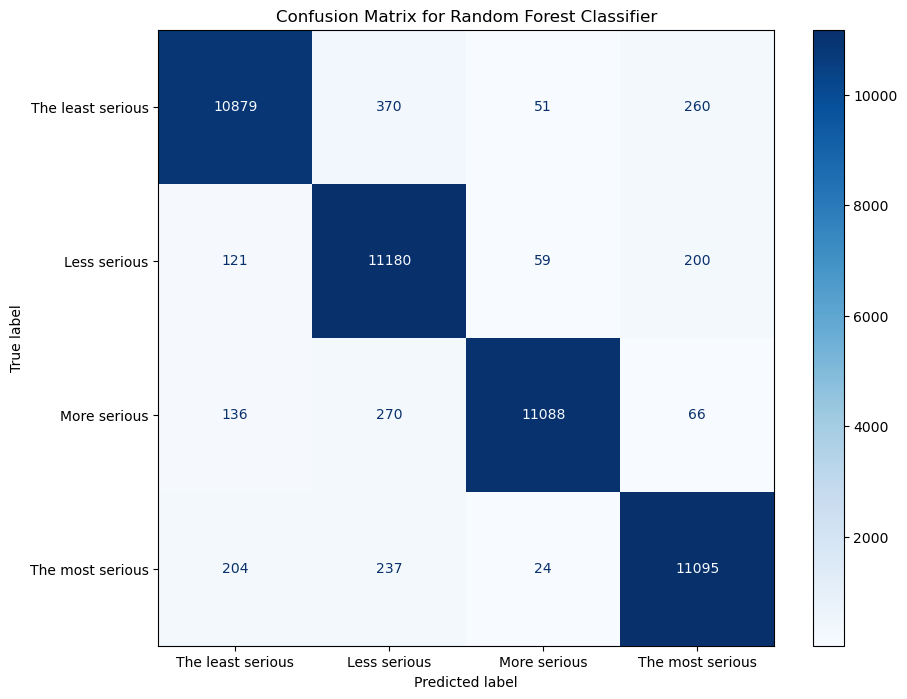

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = rfc.predict(X_resampled)

# Compute the confusion matrix
cm = confusion_matrix(y_resampled, y_pred)

# Define custom display labels
display_labels = ['The least serious', 'Less serious', 'More serious', 'The most serious']

# Increase the size of the plot
plt.figure(figsize=(10, 8))

# Display the confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

#### Load new data

In [50]:
# Now load the new encoded dataset for testing.
df_new_data = pd.read_csv('encoded_retractions_new_records_V10.csv')
df_new_data.head()

,Journal,ArticleType,CitationCount,SJR Best Quartile,SJR,H index,TimeToRetraction,IsInternationalCollaboration,ArticleAge,IsPaywalled,LevelOfSeriousness,Subject,Institution,Publisher,Country,Author,Cluster
0,457,22,0,4.0,3.785518,338.990909,266,0,11849,1,0.0,0.456673,0.000225,0.134336,0.070049,0.000097,3
1,457,7,1,4.0,3.785518,338.990909,700,0,12185,1,3.0,0.456673,0.000225,0.134336,0.274809,0.000097,3
2,462,22,8,0.0,18.509000,1391.000000,903,0,12292,0,0.0,0.456673,0.000225,0.034927,0.070049,0.000097,3
3,6,18,0,2.0,0.542000,98.000000,367,0,11805,1,0.0,0.456673,0.000225,0.010210,0.021105,0.000097,3
4,518,22,2,4.0,3.785518,338.990909,457,0,11827,0,0.0,0.518099,0.000225,0.053197,0.105074,0.000097,3


##### Balance the new data

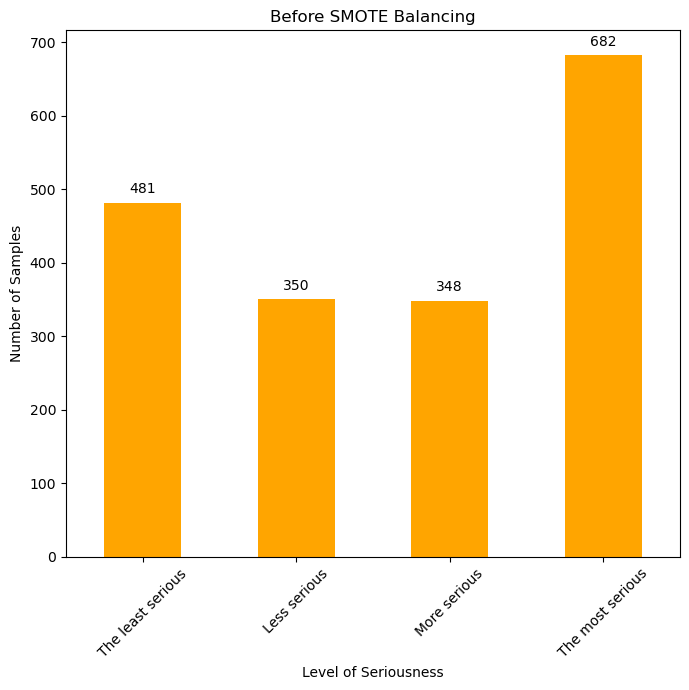

In [51]:
# Check the balance of 4 subsets in the dataset.
label_counts = df_new_data['LevelOfSeriousness'].value_counts().sort_index()  # Ensure the labels are sorted

plt.figure(figsize=(7, 7))
ax = label_counts.plot(kind='bar', color='orange')  # 'ax' captures the plot axes
plt.title('Before SMOTE Balancing')
plt.xlabel('Level of Seriousness')
plt.ylabel('Number of Samples')

# Set custom x-tick labels
plt.xticks(ticks=range(4), labels=['The least serious', 'Less serious', 'More serious', 'The most serious'], rotation=45)

# Annotate each bar with its height value
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

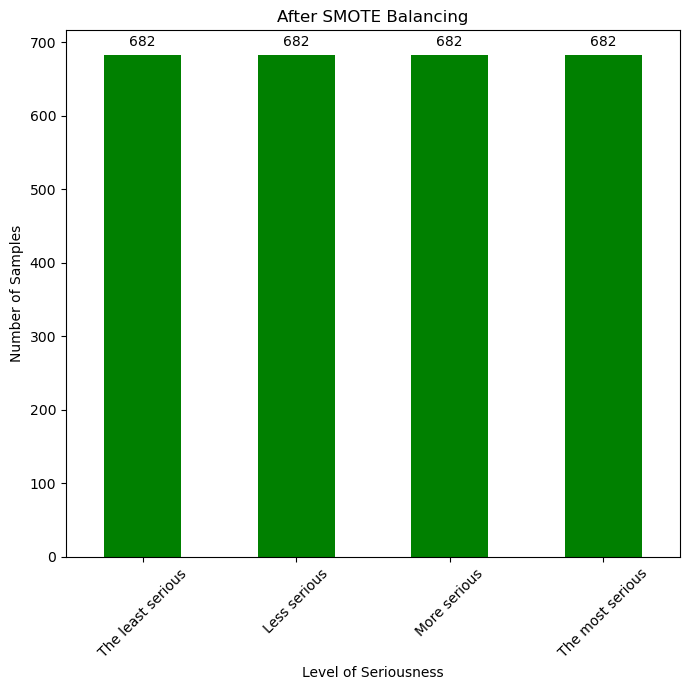

In [52]:
# Separate feataures and the target variable
X = df_new_data.drop('LevelOfSeriousness', axis=1)
y = df_new_data['LevelOfSeriousness']

# Apply SMOTE
smote = SMOTE(random_state=0)
X_resampled_new, y_resampled_new = smote.fit_resample(X, y)

# Convert y_resampled_new to a DataFrame and count the occurrences of each class
y_resampled_df = pd.DataFrame(y_resampled_new, columns=['LevelOfSeriousness'])
label_counts_resampled = y_resampled_df['LevelOfSeriousness'].value_counts().sort_index()

# Plot the balanced data
plt.figure(figsize=(7, 7))
ax = label_counts_resampled.plot(kind='bar', color='green')  # 'ax' captures the plot axes
plt.title('After SMOTE Balancing')
plt.xlabel('Level of Seriousness')
plt.ylabel('Number of Samples')

# Set custom x-tick labels
plt.xticks(ticks=range(4), labels=['The least serious', 'Less serious', 'More serious', 'The most serious'], rotation=45)

# Annotate each bar with its height value
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

##### Test the model on the new data to see if it performs well

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as calculate_f1_score, classification_report

# Making predictions with the random forest classifier
y_pred = rfc.predict(X_resampled_new)

# Calculate metrics
accuracy = accuracy_score(y_resampled_new, y_pred)
precision = precision_score(y_resampled_new, y_pred, average='macro')
recall = recall_score(y_resampled_new, y_pred, average='macro')
f1 = calculate_f1_score(y_resampled_new, y_pred, average='macro')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print(classification_report(y_resampled_new, y_pred))

Accuracy: 0.3687683284457478
Precision: 0.36003214148620677
Recall: 0.3687683284457478
F1 Score: 0.3586677379012382
              precision    recall  f1-score   support

         0.0       0.40      0.50      0.44       682
         1.0       0.35      0.40      0.37       682
         2.0       0.30      0.18      0.22       682
         3.0       0.40      0.40      0.40       682

    accuracy                           0.37      2728
   macro avg       0.36      0.37      0.36      2728
weighted avg       0.36      0.37      0.36      2728

